In [1]:
%cd ..

/nfs/scistore16/edelgrp/fzimin/depth-poset


/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
import subprocess
import inspect

import math
import numpy as np
import pandas as pd
import pickle as pkl
import networkx as nx
import gudhi as gh
import pickle as pkl

from src.depth import DepthPoset

import itertools

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from networkx import draw_networkx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import lines as mlines
from matplotlib.patches import Patch

from src.depth import DepthPoset
from src import depth_poset_similarity_scores

from tqdm import tqdm
from src.profiling import Timer


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/ipykern

AttributeError: _ARRAY_API not found

# Load and Format the Data

## Define Directories

In [3]:
# the directory to save pictures
path_to_save = 'raports/pics/torus-transpositions-extended'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

In [4]:
# the directory to load transpositions data
directory = "results/transpositions-during-linear-homotopy-between-extended-barycentric-cubical-toruses"
paths = np.sort([f'{directory}/{f}' for f in os.listdir(directory)])

## Check sizes of files

In [5]:
def get_dim_and_n_from_torus_file(path):
    with open(path, 'rb') as file:
        res = pkl.load(file)
    return res['dim'], res['n']

/tmp/ipykernel_2504006/3943854577.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_sizes[['original_path0', 'original_path1']] = df_sizes[['original_path0', 'original_path1']].applymap(lambda path: f'results/scores-on-barycentric-cubical-toruses-extended/{path}.pkl')
Extracting the Dimensions and sizes of toruses: 100%|██████████| 360/360 [00:04<00:00, 86.23it/s] 


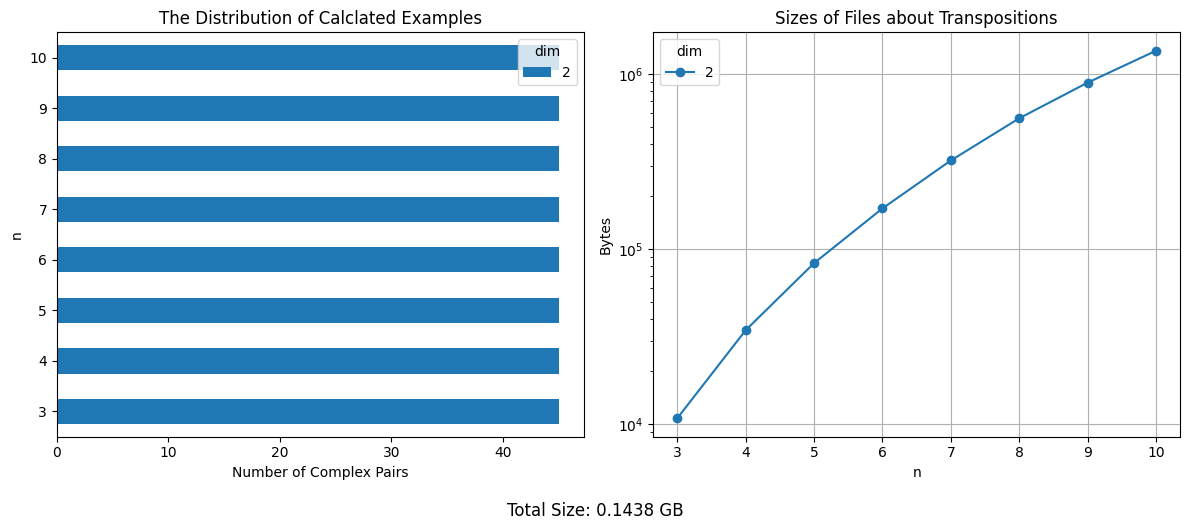

In [6]:
df_sizes = pd.DataFrame({'path': paths})
df_sizes['size'] = df_sizes['path'].apply(lambda path: os.path.getsize(path))
df_sizes['original_path0'] = df_sizes['path'].apply(lambda path: os.path.splitext(os.path.basename(path))[0].split(' and ')[0])
df_sizes['original_path1'] = df_sizes['path'].apply(lambda path: os.path.splitext(os.path.basename(path))[0].split(' and ')[1])
df_sizes[['original_path0', 'original_path1']] = df_sizes[['original_path0', 'original_path1']].applymap(lambda path: f'results/scores-on-barycentric-cubical-toruses-extended/{path}.pkl')
df_sizes['original_size0'] = df_sizes['original_path0'].apply(lambda path: os.path.getsize(path))
df_sizes['original_size1'] = df_sizes['original_path1'].apply(lambda path: os.path.getsize(path))
tqdm.pandas(desc='Extracting the Dimensions and sizes of toruses')
df_sizes['dim&n'] = df_sizes['original_path0'].progress_apply(lambda path: get_dim_and_n_from_torus_file(path))
df_sizes['dim'] = df_sizes['dim&n'].apply(lambda dimn: dimn[0])
df_sizes['n'] = df_sizes['dim&n'].apply(lambda dimn: dimn[1])
df_sizes = df_sizes.drop(columns='dim&n')


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].set_title('The Distribution of Calclated Examples')
df_sizes.groupby(['dim', 'n'])['path'].count().reset_index().pivot_table(columns='dim', index='n', values='path').fillna(0).astype(int).plot(kind='barh', ax=axs[0])
axs[0].set_xlabel('Number of Complex Pairs')

axs[1].set_title('Sizes of Files about Transpositions')
df_sizes.groupby(['dim', 'n'])['size'].mean().reset_index().pivot_table(columns='dim', index='n', values='size').plot(logy=True, marker='o', ax=axs[1])
axs[1].set_ylabel('Bytes')
axs[1].grid(True)

fig.text(0.5, -0.05, f"Total Size: {df_sizes['size'].sum()*1024**-3:.4f} GB", ha='center', va='bottom', fontsize='large')
plt.tight_layout()
plt.show()

## Load Transpositions Data

In [7]:
df = []
errs = {}
for path in tqdm(paths):
    if os.path.getsize(path) < np.inf*1024**2:
        try:
            with open(path, 'rb') as file:
                loaded_dict = pkl.load(file)
            loaded_dict['transpositions'].insert(0, 'complex_index0', loaded_dict['complex_index0'])
            loaded_dict['transpositions'].insert(1, 'complex_index1', loaded_dict['complex_index1'])
            loaded_dict['transpositions'].insert(2, 'complex_dim', loaded_dict['complex_dim'])
            loaded_dict['transpositions'].insert(3, 'complex_shape', [loaded_dict['complex_shape']]*len(loaded_dict['transpositions']))
            df.append(loaded_dict['transpositions'])

        except Exception as err:
            errs.update({path: err})
    else:
        errs.update({path: 'Giant file'})
errs = pd.Series(errs)
if len(errs) > 0:
    errs_count = errs.astype(str).value_counts()
    print(f'There is some amount of errors:\n{errs_count.to_string(name=False)}\n')
    #for path in errs.index:
    #    if os.path.exists(path):
    #        os.remove(path)
    
df = pd.concat(df)

if not 'complex_n' in df.columns: 
    df.insert(3, 'complex_n', df['complex_shape'].apply(lambda x: x[0] if (np.array(x)[1:] == np.array(x)[:-1]).all() else None))

#print(f'There are {pd.isna(df['transposition']).sum()} empty transposition values in {len(df)} lines')
#df = df[~pd.isna(df['transposition'])]
#df = df.join(df['transposition'].apply(lambda tr: tr.to_dict()).apply(pd.Series))

print(f'df.shape = {df.shape}')
df.head()

100%|██████████| 360/360 [00:02<00:00, 141.18it/s]


df.shape = (1688975, 18)


,complex_index0,complex_index1,complex_dim,complex_n,complex_shape,time,value,birth_relation_cell_similarity,death_relation_cell_similarity,poset_closure_arcs_cell_similarity,poset_reduction_arcs_cell_similarity,index 0,index 1,cell 0,cell 1,dim,type,switch
0,2025-07-15 15:04:07.297023,2025-07-15 15:04:07.336225,2,3,"(3, 3)",0.005997,2.975740,0.950000,1.0,0.976190,0.888889,34,35,"((2, 2), (2, 0), (0, 2), (0, 0))","((2, 1), (2, 2), (0, 1), (0, 2))",2,death-death,no switch
1,2025-07-15 15:04:07.297023,2025-07-15 15:04:07.336225,2,3,"(3, 3)",0.020968,1.707239,1.000000,1.0,1.000000,1.000000,24,25,"((1, 2), (2, 2))","((0, 0), (0, 1))",1,birth-birth,no switch
2,2025-07-15 15:04:07.297023,2025-07-15 15:04:07.336225,2,3,"(3, 3)",0.044589,1.692716,1.000000,1.0,1.000000,1.000000,23,24,"((1, 1), (1, 2))","((0, 0), (0, 1))",1,birth-birth,no switch
3,2025-07-15 15:04:07.297023,2025-07-15 15:04:07.336225,2,3,"(3, 3)",0.044775,1.394897,0.952381,1.0,0.976744,0.888889,15,16,"((0, 2), (1, 2))","((2, 0), (0, 0))",1,death-death,no switch
4,2025-07-15 15:04:07.297023,2025-07-15 15:04:07.336225,2,3,"(3, 3)",0.075816,1.492439,1.000000,1.0,1.000000,1.000000,18,19,"((2, 2), (2, 0))","((2, 0), (2, 1))",1,birth-birth,no switch


In [8]:
def cmap_cud(i):
    cud_colors = np.array(["#000000", "#E69F00", "#56B4E9", "#009E73", 
                           "#F0E442", "#0072B2", "#D55E00", "#CC79A7",])
    return cud_colors[i]

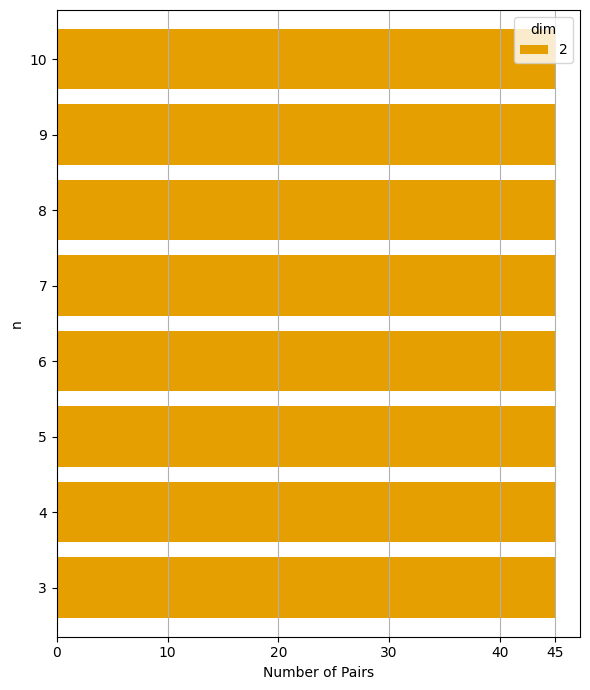

In [9]:
fig, ax = plt.subplots(figsize=(6, 7))

cmap_categorical = plt.get_cmap('Dark2')
cmap_categorical = plt.get_cmap('Accent')
cmap_categorical = cmap_cud
colors = cmap_categorical([1]) # I just seted color here to compare with scores. This will be broken, if we'll add other dimensions

df_to_plot = df.groupby(['complex_index0', 'complex_index1', 'complex_dim', 'complex_n'])['index 0'].count().reset_index().groupby(['complex_dim', 'complex_n']
            )['complex_index0'].count().reset_index().rename(columns=lambda s: s.replace('complex_', '')).pivot_table(columns='dim', index='n', values='index0').fillna(0).astype(int)
df_to_plot.plot(kind='barh', color=colors, width=0.8, ax=ax)

ax.set_xlabel('Number of Pairs')

xticks = ax.get_xticks()
xticks = np.unique(np.append(xticks[xticks <= df_to_plot.max().max()], df_to_plot.max().max())).astype(int)

ax.set_xticks(xticks)

ax.grid(axis='x')

plt.tight_layout()

plt.savefig(os.path.join(path_to_save, 'distribution.png'))

# Switch Types Distribution

In [10]:
tqdm.pandas(desc="Define switch type from type and switch columns")
df['switch type'] = df.progress_apply(lambda row: row['type'] if row['switch'] in ['switch', 'switch backward', 'switch forward'] else row['switch'], axis=1)

df['switch type'].value_counts()

Define switch type from type and switch columns: 100%|██████████| 1688975/1688975 [00:18<00:00, 89678.32it/s] 


switch type
no switch      1631909
birth-birth      23723
death-death      20595
birth-death      12748
Name: count, dtype: int64

In [11]:
# define colors and markers
switch_type_colors = pd.Series({
    'no switch': '#000000',    # black
    'birth-birth': '#0072B2',  # blue (CUD-safe)
    'birth-death': '#E69F00',  # orange (CUD-safe)
    'death-death': '#CC79A7',  # purple/pinkish (CUD-safe)
}, name='color')
switch_type_markers = pd.Series({
    'no switch': 'o',
    'birth-birth': '^',
    'birth-death': 'X',
    'death-death': 'v',
}, name='marker')

pd.DataFrame([switch_type_colors, switch_type_markers])

,no switch,birth-birth,birth-death,death-death
color,#000000,#0072B2,#E69F00,#CC79A7
marker,o,^,X,v


In [12]:
df_switch_types = df.copy()

with Timer() as timer:
    df_switch_types = df_switch_types.groupby(['complex_index0', 'complex_index1', 'complex_dim', 'complex_n', 'dim', 'switch type'])['index 0'].count().reset_index().rename(columns={'index 0': 'count'})
    print(f'Calculated counts-values for each type in {timer.elapsed():.4f} seconds.')
    timer.checkpoint()
    
    df_switch_types_mean = df_switch_types.groupby(['complex_dim', 'complex_n', 'dim', 'switch type'])['count'].mean().reset_index()
    df_switch_types_mean = df_switch_types_mean.pivot_table(index='complex_n', columns=['complex_dim', 'dim', 'switch type'], values='count')
    df_switch_types_mean.index.name = 'n'
    print(f'Calculated mean count in {timer.elapsed():.4f} seconds.')
    timer.checkpoint()
    

    df_switch_types_std = df_switch_types.groupby(['complex_dim', 'complex_n', 'dim', 'switch type'])['count'].std().reset_index()
    df_switch_types_std = df_switch_types_std.pivot_table(index='complex_n', columns=['complex_dim', 'dim', 'switch type'], values='count')
    df_switch_types_std.index.name = 'n'
    print(f'Calculated variation count in {timer.elapsed():.4f} seconds.')

df_switch_types_mean = df_switch_types_mean.sort_index(axis=1)
df_switch_types_std = df_switch_types_std.sort_index(axis=1)

complex_dims = pd.unique(df['complex_dim'])
transposition_dims = pd.unique(df['dim'])

print()
print(f'df_switch_types_std.shape = {df_switch_types_std.shape}')
print('...\n')
print(f'df_switch_types_mean.shape = {df_switch_types_mean.shape}')
df_switch_types_mean.head()


Calculated counts-values for each type in 0.4885 seconds.
Calculated mean count in 0.0082 seconds.
Calculated variation count in 0.0057 seconds.

df_switch_types_std.shape = (8, 10)
...

df_switch_types_mean.shape = (8, 10)


complex_dim           2                                                  \
dim                   0                                   1               
switch type birth-birth birth-death   no switch birth-birth birth-death   
n                                                                         
3              2.634146    1.222222   13.688889    8.333333    5.088889   
4              5.069767    2.250000   49.422222   14.577778   10.044444   
5              9.177778    2.318182  144.266667   24.822222   15.688889   
6             14.177778    2.704545  291.133333   34.066667   22.511111   
7             20.022222    2.266667  550.155556   45.155556   31.355556   

complex_dim                                                               
dim                                            2                          
switch type death-death    no switch birth-death death-death   no switch  
n                                                                         
3              3.933333    59.000000    1.952381    2.785714   13.844444  
4              9.088889   220.488889    1.860465    5.022222   53.266667  
5             17.000000   545.555556    2.000000    9.488889  138.888889  
6             26.400000  1175.711111    2.720930   13.622222  289.488889  
7             39.200000  2226.511111    2.363636   19.711111  580.000000

In [13]:
pictypes_filename_template = 'transposition-types-complex-dim{complex_dim}-subposet-dim{dim}-drop-no-switches-{drop_no_switch}.png'

In [14]:
for irow, row in df_switch_types_mean.columns.to_frame()[['complex_dim', 'dim']].drop_duplicates().reset_index(drop=True).iterrows():
    complex_dim, dim = row
    for drop_no_switch in np.arange(2).astype(bool):
        row['drop_no_switch'] = drop_no_switch
        path = os.path.join(path_to_save, pictypes_filename_template.format(**row))
        df_this_mean = df_switch_types_mean[complex_dim][dim]
        df_this_std = df_switch_types_std[complex_dim][dim]

        if drop_no_switch:
            df_this_mean = df_this_mean.drop(columns='no switch')
            df_this_std = df_this_std.drop(columns='no switch')

        assert df_this_mean.columns.to_list() == df_this_std.columns.to_list()
        assert df_this_mean.index.to_list() == df_this_std.index.to_list()
        
        for col in df_this_mean.columns:
            x = df_this_mean.index.values
            y_mean = df_this_mean[col].values
            y_std = df_this_std[col].values
            plt.plot(x, y_mean, color=switch_type_colors[col], marker=switch_type_markers[col], label=col, linewidth=2, markersize=8, zorder=1)
            plt.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.2, color=switch_type_colors[col], zorder=0)

        plt.grid(True)
        plt.legend()
        plt.xlabel('$n$')
        plt.tight_layout()
        plt.savefig(path)
        plt.close()

In [15]:
figure_2_layers_template = r"""
\begin{{figure}}[htbp]
\centering
{level0}
\vspace{{0.5cm}}
{level1}
\caption{{{caption}}}
\label{{{label}}}
\end{{figure}}
""".strip()

subfigure_template = r"""
\begin{{subfigure}}[b]{{{figwidth}\textwidth}}
    \includegraphics[width=\linewidth]{{{path}}}
    \caption{{{caption}}}
    \label{{{label}}}
\end{{subfigure}}
""".strip()


In [16]:
typedistribution_prefix_template = """
\\par The distribution of transpositions types for the model $\\mathbb{{T}}^{{{complex_dim}}}_n$ we can see in the figure Fig. \\ref{{{label}}}.
"""

In [17]:
switch_type_distributions_ltx = []

for complex_dim in pd.unique(df_switch_types['complex_dim']):
    

    figwidth = round(0.90/(complex_dim + 1), 2)

    subfigures_level0 = []
    subfigures_level1 = []
    
    for dim in range(complex_dim + 1):
        path = os.path.join(path_to_save, pictypes_filename_template.format(complex_dim=complex_dim, dim=dim, drop_no_switch=False))
        path = path.replace('raports/', '')
        caption = f"Cells dimension {dim}"
        label = f'fig:complex{complex_dim}cells{dim}'
        subfigures_level0.append(subfigure_template.format(figwidth=figwidth, path=path, caption=caption, label=label))

        path = os.path.join(path_to_save, pictypes_filename_template.format(complex_dim=complex_dim, dim=dim, drop_no_switch=True))
        path = path.replace('raports/', '')
        caption = f"Cells dimension {dim} (without no switch transpositions)"
        label = f'fig:complex{complex_dim}cells{dim}onlyswitch'
        subfigures_level1.append(subfigure_template.format(figwidth=figwidth, path=path, caption=caption, label=label))
    
    level0 = '\n\\hfill\n'.join(subfigures_level0)
    level1 = '\n\\hfill\n'.join(subfigures_level1)
    caption = f'The switch type distribution for $\\mathbb{{T}}_n^{{{complex_dim}}}$'
    label = 'fig:' + f'typesdistribution{complex_dim}'
    
    text0 = typedistribution_prefix_template.format(complex_dim=complex_dim, label=label)
    text1 = figure_2_layers_template.format(level0=level0, level1=level1, caption=caption, label=label)
    switch_type_distributions_ltx.append(text0 + text1)

switch_type_distributions_ltx = '\n\n'.join(switch_type_distributions_ltx)
print(switch_type_distributions_ltx)


\par The distribution of transpositions types for the model $\mathbb{T}^{2}_n$ we can see in the figure Fig. \ref{fig:typesdistribution2}.
\begin{figure}[htbp]
\centering
\begin{subfigure}[b]{0.3\textwidth}
    \includegraphics[width=\linewidth]{pics/torus-transpositions-extended/transposition-types-complex-dim2-subposet-dim0-drop-no-switches-False.png}
    \caption{Cells dimension 0}
    \label{fig:complex2cells0}
\end{subfigure}
\hfill
\begin{subfigure}[b]{0.3\textwidth}
    \includegraphics[width=\linewidth]{pics/torus-transpositions-extended/transposition-types-complex-dim2-subposet-dim1-drop-no-switches-False.png}
    \caption{Cells dimension 1}
    \label{fig:complex2cells1}
\end{subfigure}
\hfill
\begin{subfigure}[b]{0.3\textwidth}
    \includegraphics[width=\linewidth]{pics/torus-transpositions-extended/transposition-types-complex-dim2-subposet-dim2-drop-no-switches-False.png}
    \caption{Cells dimension 2}
    \label{fig:complex2cells2}
\end{subfigure}
\vspace{0.5cm}
\begin{

# Similarity Scores

In [18]:
scores = df.columns.values
scores = scores[np.isin(scores, [name for name, f in inspect.getmembers(depth_poset_similarity_scores, inspect.isfunction)])]
scores = scores.tolist()
scores

['birth_relation_cell_similarity',
 'death_relation_cell_similarity',
 'poset_closure_arcs_cell_similarity',
 'poset_reduction_arcs_cell_similarity']

In [19]:
df[['complex_dim', 'complex_n'] + scores].groupby(['complex_dim', 'complex_n']).count()

birth_relation_cell_similarity  \
complex_dim complex_n                                   
2           3                                    5026   
            4                                   16674   
            5                                   40910   
            6                                   84256   
            7                                  158251   
            8                                  275389   
            9                                  439819   
            10                                 668650   

                       death_relation_cell_similarity  \
complex_dim complex_n                                   
2           3                                    5026   
            4                                   16674   
            5                                   40910   
            6                                   84256   
            7                                  158251   
            8                                  275389   
            9                                  439819   
            10                                 668650   

                       poset_closure_arcs_cell_similarity  \
complex_dim complex_n                                       
2           3                                        5026   
            4                                       16674   
            5                                       40910   
            6                                       84256   
            7                                      158251   
            8                                      275389   
            9                                      439819   
            10                                     668650   

                       poset_reduction_arcs_cell_similarity  
complex_dim complex_n                                        
2           3                                          5026  
            4                                         16674  
            5                                         40910  
            6                                         84256  
            7                                        158251  
            8                                        275389  
            9                                        439819  
            10                                       668650

In [20]:
df_scores_mean = df[['complex_dim', 'complex_n', 'dim', 'switch type'] + scores].groupby(['complex_dim', 'complex_n', 'dim', 'switch type']).mean()
df_scores_std = df[['complex_dim', 'complex_n', 'dim', 'switch type'] + scores].groupby(['complex_dim', 'complex_n', 'dim', 'switch type']).std()

def regroup_df(df):
    df = df.reset_index(drop=False)
    df = df.melt(id_vars=['complex_dim', 'complex_n', 'dim', 'switch type'], value_vars=scores, var_name='score', value_name='value')
    df = df.pivot_table(index='complex_n', columns=['score', 'complex_dim', 'dim', 'switch type'], values='value')
    return df

df_scores_mean = regroup_df(df_scores_mean)
df_scores_std = regroup_df(df_scores_std)

print(f'df_scores_mean.shape = {df_scores_mean.shape}')
print(f'df_scores_std.shape = {df_scores_std.shape}')

assert (df_scores_mean.columns == df_scores_std.columns).all()
assert (df_scores_mean.index == df_scores_std.index).all()

nrows = min(5, len(df_scores_mean))
pd.concat([df_scores_mean.head(nrows), df_scores_std.head(nrows)])

df_scores_mean.shape = (8, 40)
df_scores_std.shape = (8, 40)


score       birth_relation_cell_similarity                                    \
complex_dim                              2                                     
dim                                      0                                 1   
switch type                    birth-birth birth-death no switch birth-birth   
complex_n                                                                      
3                                 0.687901    0.787225       1.0    0.512950   
4                                 0.785698    0.845227       1.0    0.651831   
5                                 0.832331    0.877027       1.0    0.757027   
6                                 0.860037    0.877811       1.0    0.823986   
7                                 0.894731    0.890173       1.0    0.855070   
3                                 0.112861    0.077755       0.0    0.122950   
4                                 0.109386    0.083970       0.0    0.114169   
5                                 0.085794    0.055418       0.0    0.089055   
6                                 0.081029    0.064248       0.0    0.076676   
7                                 0.070557    0.053427       0.0    0.070709   

score                                                                  \
complex_dim                                                             
dim                                                     2               
switch type birth-death death-death no switch birth-death death-death   
complex_n                                                               
3              0.594658    0.757973  0.992995    0.743422    0.548589   
4              0.713978    0.811019  0.996923    0.810621    0.694802   
5              0.781100    0.841649  0.998493    0.838134    0.795074   
6              0.842465    0.879170  0.999071    0.869087    0.844676   
7              0.872783    0.905085  0.999472    0.912646    0.877515   
3              0.144103    0.131340  0.024261    0.139475    0.146555   
4              0.132447    0.105133  0.012745    0.086660    0.105031   
5              0.110448    0.088717  0.007153    0.065089    0.086565   
6              0.094708    0.073551  0.004911    0.057826    0.070896   
7              0.077096    0.058757  0.003172    0.041090    0.066303   

score                  ... poset_reduction_arcs_cell_similarity              \
complex_dim            ...                                    2               
dim                    ...                                    0               
switch type no switch  ...                          birth-birth birth-death   
complex_n              ...                                                    
3            0.965031  ...                             0.670694    0.782260   
4            0.989790  ...                             0.780949    0.846487   
5            0.996063  ...                             0.831126    0.883919   
6            0.998015  ...                             0.870111    0.905518   
7            0.998833  ...                             0.900501    0.916602   
3            0.063171  ...                             0.095180    0.070828   
4            0.026596  ...                             0.090151    0.065554   
5            0.013451  ...                             0.069221    0.047642   
6            0.007839  ...                             0.061259    0.038490   
7            0.005310  ...                             0.054491    0.035983   

score                                                                \
complex_dim                                                           
dim                             1                                     
switch type no switch birth-birth birth-death death-death no switch   
complex_n                                                             
3            0.976696    0.576925    0.600101    0.686544  0.975826   
4            0.992118    0.711992    0.735038    0.780050  0.990594   
5            0.99613

In [21]:
picscores_filename_template = 'score-{score}-complex-dim{complex_dim}-transpositions-dim{dim}.png'

100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


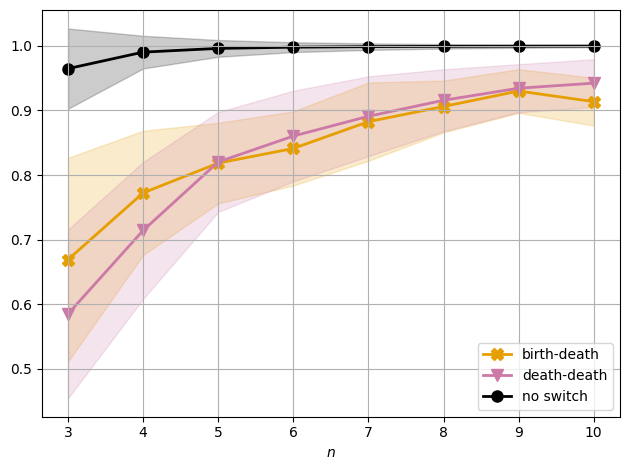

In [22]:
rows = df_scores_mean.columns.to_frame()[['score', 'complex_dim', 'dim']].drop_duplicates().reset_index(drop=True)

for i, (score, complex_dim, dim) in tqdm(rows.iterrows(), total=len(rows)):
    path = os.path.join(path_to_save, picscores_filename_template.format(score=score.replace('_', '-'), complex_dim=complex_dim, dim=dim))

    df_this_mean = df_scores_mean[score][complex_dim][dim]
    df_this_std = df_scores_std[score][complex_dim][dim]

    for col in df_this_mean.columns:
        x = df_this_mean.index.values
        y_mean = df_this_mean[col].values
        y_std = df_this_std[col].values
        plt.plot(x, y_mean, color=switch_type_colors[col], marker=switch_type_markers[col], label=col, linewidth=2, markersize=8, zorder=1)
        plt.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.2, color=switch_type_colors[col], zorder=0)

    plt.grid(True)
    plt.legend()
    plt.xlabel('$n$')
    #plt.ylabel(score)
    plt.tight_layout()
    plt.savefig(path)
    if i < len(rows) - 1:
        plt.close()
plt.show()

In [23]:
figure_1_layer_template = r"""
\begin{{figure}}[htbp]
\centering
{subfigures}
\caption{{{caption}}}
\label{{{label}}}
\end{{figure}}
""".strip()

In [24]:
def latexize(score):
    return score.replace('_', r'\_')

def labelize(label):
    return label.replace('_', '')

In [25]:
score_label_template = 'fig:{score}complex{complex_dim}'

In [26]:
scores_ltx_pics = []

rows = df_scores_mean.columns.to_frame()[['score', 'complex_dim']].drop_duplicates().reset_index(drop=True)

for irow, (score, complex_dim) in rows.iterrows():
    figwidth = round(0.90/(complex_dim + 1), 2)

    subfigures = []
    for dim in range(complex_dim + 1):
        path = os.path.join(path_to_save, picscores_filename_template.format(score=score.replace('_', '-'), complex_dim=complex_dim, dim=dim))
        path = path.replace(r'raports/', '')
        caption = f"Cells dimension {dim}"
        label = f'fig:{labelize(score)}complex{complex_dim}cells{dim}'
        subfigures.append(subfigure_template.format(figwidth=figwidth, path=path, caption=caption, label=label))
    
    subfigures = '\n\\hfill\n'.join(subfigures)
    caption = f'Similarity score {latexize(score)} for $\\mathbb{{T}}_n^{{{complex_dim}}}$'
    label = score_label_template.format(complex_dim=complex_dim, score=score.replace('_', ''))
    scores_ltx_pics.append(figure_1_layer_template.format(subfigures=subfigures, caption=caption, label=label))
scores_ltx_pics = '\n\n'.join(scores_ltx_pics)

In [27]:
score_item_template = """
\\item \\textbf{{{score}}} - {descr}
""".strip()

scores_ltx_descr = [score_item_template.format(score=latexize(score), descr=getattr(depth_poset_similarity_scores, score).__doc__.strip()) for score in scores]
scores_ltx_descr = '\n'.join(scores_ltx_descr)
scores_ltx_descr = f"""
\\begin{{itemize}}
{scores_ltx_descr}
\\end{{itemize}}
""".strip()

print(scores_ltx_descr)

\begin{itemize}
\item \textbf{birth\_relation\_cell\_similarity} - The Jacard index of arcs (edges) in the birth relation (given by row left to right reduction algorithm).
    Consider 2 birth-death pairs are similar if they corespond the similar cells.
\item \textbf{death\_relation\_cell\_similarity} - The Jacard index of arcs (edges) in the death relation (given by column bottom to top reduction algorithm).
    Consider 2 birth-death pairs are similar if they corespond the similar cells.
\item \textbf{poset\_closure\_arcs\_cell\_similarity} - The Jacard index of arcs (edges) in the transitive closure of the Depth Posets.
    Consider 2 birth-death pairs are similar if they corespond the similar cells.
\item \textbf{poset\_reduction\_arcs\_cell\_similarity} - The Jacard index of arcs (edges) in the transitive reduction of the Depth Posets.
    Consider 2 birth-death pairs are similar if they corespond the similar cells.
\end{itemize}


In [28]:
df_scoredim_status = df.groupby('complex_dim')[scores].count() > 0

df_scoredim = pd.DataFrame([[score_label_template.format(complex_dim=dim, score=score.replace('_', '')) for score in df_scoredim_status.columns] for dim in df_scoredim_status.index], 
                           columns=df_scoredim_status.columns, index=df_scoredim_status.index).map(lambda ref: f'Fig. \\ref{{{ref}}}')
df_scoredim.where(df_scoredim_status, '', inplace=True)

df_scoredim.index.name = 'dim'
df_scoredim = df_scoredim.rename(columns=latexize)

df_scoredim

,birth\_relation\_cell\_similarity,death\_relation\_cell\_similarity,poset\_closure\_arcs\_cell\_similarity,poset\_reduction\_arcs\_cell\_similarity
dim,,,,
2,Fig. \ref{fig:birthrelationcellsimilaritycompl...,Fig. \ref{fig:deathrelationcellsimilaritycompl...,Fig. \ref{fig:posetclosurearcscellsimilarityco...,Fig. \ref{fig:posetreductionarcscellsimilarity...


In [29]:
scores_ltx_table = f"""
\\par The distribution of the similarity scores for different models $\\mathbb{{T}}^{{dim}}_n$ we can see in the following figures:

{df_scoredim.transpose().to_latex()}
""".strip()

print(scores_ltx_table)

\par The distribution of the similarity scores for different models $\mathbb{T}^{dim}_n$ we can see in the following figures:

\begin{tabular}{ll}
\toprule
dim & 2 \\
\midrule
birth\_relation\_cell\_similarity & Fig. \ref{fig:birthrelationcellsimilaritycomplex2} \\
death\_relation\_cell\_similarity & Fig. \ref{fig:deathrelationcellsimilaritycomplex2} \\
poset\_closure\_arcs\_cell\_similarity & Fig. \ref{fig:posetclosurearcscellsimilaritycomplex2} \\
poset\_reduction\_arcs\_cell\_similarity & Fig. \ref{fig:posetreductionarcscellsimilaritycomplex2} \\
\bottomrule
\end{tabular}


In [30]:
scores_ltx = f"""
{scores_ltx_descr}
{scores_ltx_table}
{scores_ltx_pics}
"""

# Compile report

In [31]:
# load texts, describing the process
with open('texts/extended-barycentric-cubical-torus-transpositions - descr.txt', 'r') as file:
    s_descr = file.read()

# load LaTeX template
with open('texts/template.tex', 'r') as file:
    ltx_latex = file.read()

In [32]:
body = f"""
\\section{{Description}}
{s_descr}
\\newpage

\\section{{Switch Types Distributions}}
{switch_type_distributions_ltx}
\\newpage

\\section{{Similarity Scores}}
{scores_ltx}

"""

raport = ltx_latex.replace('BODY', body)

In [33]:
with open('raports/extended-barycentric-torus-transpositions.tex', 'w') as file:
    file.write(raport)


In [34]:
os.chdir('raports')
result = subprocess.run(
    ['pdflatex', 'extended-barycentric-torus-transpositions.tex'],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True
)
os.chdir('..')